In [67]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# set traditional Chinese display
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

In [107]:
# Load the datasets
data = pd.read_csv('../dataset/doubles 2/doubles/convert_shot.csv', encoding='utf-8')
rally_data = pd.read_csv('../dataset/doubles 2/doubles/rally.csv', encoding='utf-8')
set_data = pd.read_csv('../dataset/doubles 2/doubles/set.csv', encoding='utf-8')

# Filter players
players_filtered = data[~((data['rally_id'] >= 73) & (data['rally_id'] <= 143))]

# Get the maximum shot number for each rally
max_shots_per_rally = players_filtered.groupby('rally_id')['shot_num'].max().reset_index()
max_shots_per_rally.columns = ['rally_id', 'max_shot_num']

# Merge the max_shots_per_rally back to the players_filtered
players_filtered = players_filtered.merge(max_shots_per_rally, on='rally_id', how='left')

# Merge rally_data with set_data to include set_win information
rally_set_merged = rally_data.merge(set_data[['set_id', 'set_win']], on='set_id', how='left')

# Initialize the list to collect rows
rows_list_win = []
rows_list_lose = []

# Initialize previous shot variable
prev = ""

# Iterate over the filtered DataFrame rows
for idx, row in players_filtered.iterrows():
    if row['shot_num'] == 1:
        continue

    # Check ball type
    if row['ball_type'] in ['擋小球', '勾球', '放小球', '小平球']:
        row['ball_type'] = '網前小球'
    elif row['ball_type'] == '防守回挑':
        row['ball_type'] = '挑球'
    elif row['ball_type'] in ['防守回抽', '後場抽平球']:
        row['ball_type'] = '平球'
    elif row['ball_type'] == '過度切球':
        row['ball_type'] = '切球'
    elif row['ball_type'] in ['推球', '撲球']:
        row['ball_type'] = '推撲球'

    if row['player'] != 14 and row['player'] != 33:
        prev = row["ball_type"]
        continue

    newrow = {
        "shot_id": row["shot_id"],
        "up_court": 0,
        "score": 0,
        "hit_player_x": None,
        "hit_player_y": None,
        "partner_x": None,
        "partner_y": None,
        "ball_type": row["ball_type"],
        "挑球": 0,
        "殺球": 0,
        "平球": 0,
        "網前小球": 0,
        "切球": 0,
        "推撲球": 0,
        "長球": 0
    }
    # print(row)
    if not ((row['hit_y'] < 67) ^ (row['player_A_y'] < 67)):
        if row['player'] == 14:
            newrow["hit_player_x"] = row['player_A_x']
            newrow["hit_player_y"] = row['player_A_y']
            newrow["partner_x"] = row['player_B_x']
            newrow["partner_y"] = row['player_B_y']
        else:
            newrow["hit_player_x"] = row['player_B_x']
            newrow["hit_player_y"] = row['player_B_y']
            newrow["partner_x"] = row['player_A_x']
            newrow["partner_y"] = row['player_A_y']
    else:
        if row['player'] == 14:
            newrow["hit_player_x"] = row['player_C_x']
            newrow["hit_player_y"] = row['player_C_y']
            newrow["partner_x"] = row['player_D_x']
            newrow["partner_y"] = row['player_D_y']
        else:
            newrow["hit_player_x"] = row['player_D_x']
            newrow["hit_player_y"] = row['player_D_y']
            newrow["partner_x"] = row['player_C_x']
            newrow["partner_y"] = row['player_C_y']

    if newrow["hit_player_y"] > 67:
        newrow["up_court"] = 1
        newrow["hit_player_x"] = 61 - newrow["hit_player_x"]
        newrow["hit_player_y"] = 134 - newrow["hit_player_y"]
        newrow["partner_x"] = 61 - newrow["partner_x"]
        newrow["partner_y"] = 134 - newrow["partner_y"]

    newrow[f'{prev}'] = 1

    # Ensure only valid ball types are added
    newrow["ball_type"] = row["ball_type"]

    # Filter out the first match (lose)
    if row['rally_id'] <= 1479 and row['rally_id'] >= 1414:
        # Check if the current shot is one of the last two shots in the rally
        if row['shot_num'] >= row['max_shot_num'] - 1:
            rally_info = rally_set_merged[rally_set_merged['rally_id'] == row['rally_id']].iloc[0]
            set_win = rally_info['set_win']
            score_team = rally_info['score_team']

            if set_win == 1:
                if score_team == 0:
                    score_result = -1
                else:
                    score_result = 1
            else:
                if score_team == 0:
                    score_result = 1
                else:
                    score_result = -1
            newrow["score"] = score_result
        rows_list_lose.append(newrow)
    else:
        # Check if the current shot is one of the last two shots in the rally
        if row['shot_num'] >= row['max_shot_num'] - 1:
            rally_info = rally_set_merged[rally_set_merged['rally_id'] == row['rally_id']].iloc[0]
            set_win = rally_info['set_win']
            score_team = rally_info['score_team']

            if set_win == 1:
                if score_team == 0:
                    score_result = -1
                else:
                    score_result = 1
            else:
                if score_team == 0:
                    score_result = 1
                else:
                    score_result = -1
            newrow["score"] = score_result
        rows_list_win.append(newrow)
    # print(newrow)

# Create a new DataFrame from the list of rows
win_df = pd.DataFrame(rows_list_win)
lose_df = pd.DataFrame(rows_list_lose)

# Define the desired column order
column_order = [
    "shot_id", "up_court", "hit_player_x", "hit_player_y", "partner_x", "partner_y",
    "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球", "ball_type", "score"
]

# Reorder the columns
win_df = win_df[column_order]
lose_df = lose_df[column_order]

win_df.to_csv('../dataset/doubles 2/doubles/processed_shot_win.csv', index=False, encoding='utf-8')
lose_df.to_csv('../dataset/doubles 2/doubles/processed_shot_lose.csv', index=False, encoding='utf-8')

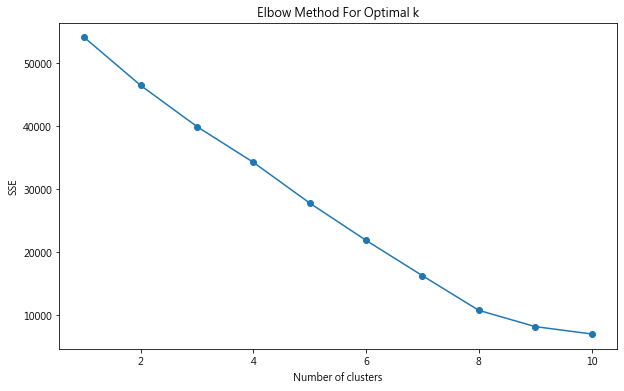

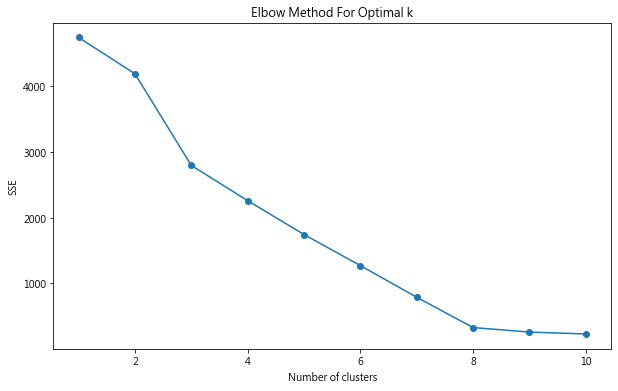

In [108]:
dataset_name = ['win', 'lose']
win_data = pd.read_csv('../dataset/doubles 2/doubles/processed_shot_win.csv')
lose_data = pd.read_csv('../dataset/doubles 2/doubles/processed_shot_lose.csv')

for name in dataset_name:
    data = win_data if name == 'win' else lose_data
    # select features
    features = data[["hit_player_x", "hit_player_y", "partner_x", "partner_y",
        "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]]
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # use elbow method to find the optimal k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        sse.append(kmeans.inertia_)

    # plot the elbow method
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.title('Elbow Method For Optimal k')
    plt.savefig(f'../output/Week6/elbow_plot_{name}.png')
    plt.show()

In [113]:
dataset_name = ['win', 'lose']

# clustering
n_win = 8  # Best n from elbow method
kmeans_win = KMeans(n_clusters=n_win)
win_df['cluster'] = kmeans_win.fit_predict(win_df[["hit_player_x", "hit_player_y", "partner_x", "partner_y",
        "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]])
win_df.to_csv('../dataset/doubles 2/doubles/processed_shot_win.csv', index=False)

n_lose = 8
kmeans_lose = KMeans(n_clusters=n_lose)
lose_df['cluster'] = kmeans_lose.fit_predict(lose_df[["hit_player_x", "hit_player_y", "partner_x", "partner_y",
        "挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]])
lose_df.to_csv('../dataset/doubles 2/doubles/processed_shot_lose.csv', index=False)


In [114]:
# plot the clustering result
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# data_indices = data.index

for name in dataset_name:
    n = n_win if name == 'win' else n_lose
    data = win_df if name == 'win' else lose_df
    for cluster in range(0, n):
        plt.figure(figsize=(9.15, 10.05))
    
        cluster_data = data[data['cluster'] == cluster]
        if len(cluster_data) > 60:
            sample_cluster_data = cluster_data.sample(n=60, random_state=1)
        else:
            sample_cluster_data = cluster_data
    
        plt.scatter(sample_cluster_data['hit_player_x'], sample_cluster_data['hit_player_y'], color='r', label=f'Cluster {cluster} - Hit player')
        plt.plot([sample_cluster_data['hit_player_x'], sample_cluster_data['partner_x']], [sample_cluster_data['hit_player_y'], 
            sample_cluster_data['partner_y']], color='y', label=f'Cluster {cluster} - Partner line') 
        plt.scatter(sample_cluster_data['partner_x'], sample_cluster_data['partner_y'], color='b', label=f'Cluster {cluster} - Partner')
        plt.plot([sample_cluster_data['hit_player_x'].mean(), sample_cluster_data['partner_x'].mean()], [sample_cluster_data['hit_player_y'].mean(), 
            sample_cluster_data['partner_y'].mean()], color='g', label=f'Cluster {cluster} - Mean line', linewidth=5)
    
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.xlim(0, 61) 
        plt.ylim(0, 67) 
        plt.savefig(f'../output/Week6/{name}_cluster_{cluster+1}_positions.jpg')
        plt.close()


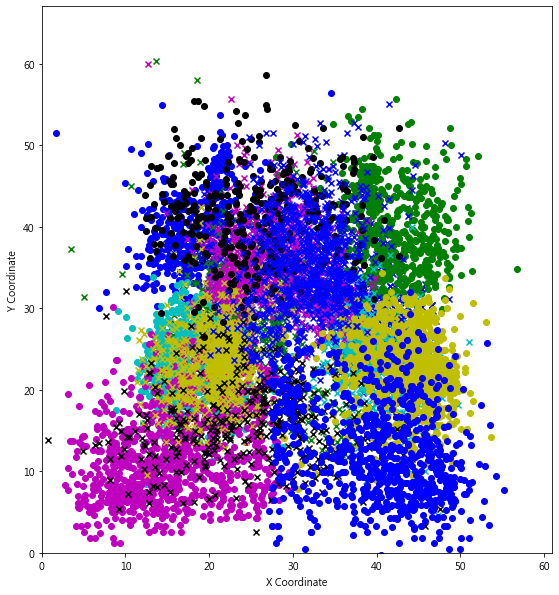

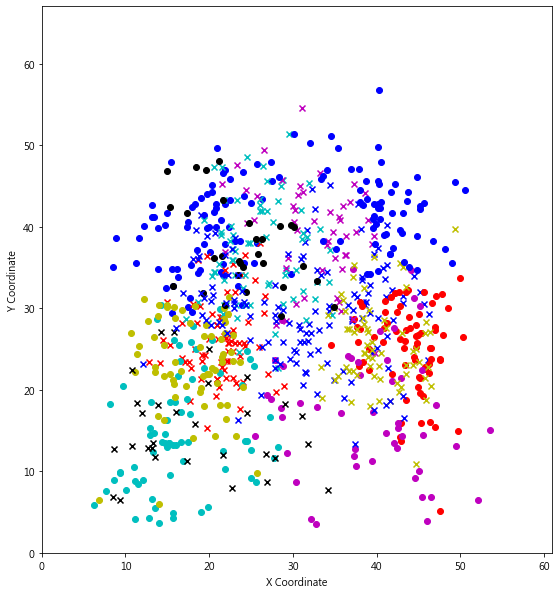

In [115]:
for name in dataset_name:
    data = win_df if name == 'win' else lose_df
    # plot all clustering results in one figure
    plt.figure(figsize=(9.15, 10.05))
    for cluster in range(n):
        cluster_data = data[data['cluster'] == cluster]
        plt.scatter(cluster_data['hit_player_x'], cluster_data['hit_player_y'], 
            color=colors[cluster % len(colors)], label=f'Cluster {cluster} - Hit player')
        plt.scatter(cluster_data['partner_x'], cluster_data['partner_y'], 
            color=colors[cluster % len(colors)], marker='x', label=f'Cluster {cluster} - Partner')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(0, 61) 
    plt.ylim(0, 67)
    # plt.legend()
    plt.savefig(f'../output/Week6/{name}_clusters_positions.jpg')
    plt.show()

In [126]:
# Define the ball types
ball_types = ["挑球", "殺球", "平球", "網前小球", "切球", "推撲球", "長球"]

for name in dataset_name:
    data = win_df if name == 'win' else lose_df
    n = n_win if name == 'win' else n_lose
    
    # Transform one-hot encoding to ball type strings for the opponent's shots
    data['opponent_ball_type'] = data[ball_types].idxmax(axis=1)
    print(name)
    for cluster in range(n):
        clustered_data = data[data['cluster'] == cluster]
        matrix = pd.crosstab(clustered_data['opponent_ball_type'], clustered_data['ball_type'], dropna=False)
        matrix = matrix.reindex(index=ball_types, columns=ball_types, fill_value=0)
        
        # Calculate the percentage matrix
        matrix_percentage = matrix / matrix.values.sum() * 100
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix_percentage, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=ball_types, yticklabels=ball_types)
        plt.xlabel("Our hit ball type")
        plt.ylabel("Opponent's hit ball type")
        plt.yticks(rotation=45)
        plt.title(f'Confusion Matrix (Percentage) for {name.capitalize()} Cluster {cluster+1}')
        plt.savefig(f'../output/Week6/{name}_cluster_{cluster+1}_confusion_matrix_percentage.jpg')
        plt.close()
        
        # Calculate winning rate and losing rate
        print(cluster)
        print("scoring ratio:",clustered_data['score'][clustered_data['score']==1].count()/clustered_data['shot_id'].count())
        print("lose scoore ratio:",clustered_data['score'][clustered_data['score']==-1].count()/clustered_data['shot_id'].count())


win
0
scoring ratio: 0.04251012145748988
lose scoore ratio: 0.044534412955465584
1
scoring ratio: 0.043478260869565216
lose scoore ratio: 0.050434782608695654


c:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


2
scoring ratio: 0.0
lose scoore ratio: 0.0
3
scoring ratio: 0.0453920220082531
lose scoore ratio: 0.052269601100412656
4
scoring ratio: 0.036669970267591674
lose scoore ratio: 0.03369672943508424
5
scoring ratio: 0.03504928806133625
lose scoore ratio: 0.06790799561883899
6
scoring ratio: 0.09375
lose scoore ratio: 0.06770833333333333
7
scoring ratio: 0.02586206896551724
lose scoore ratio: 0.046798029556650245
lose
0
scoring ratio: 0.04225352112676056
lose scoore ratio: 0.07042253521126761


c:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:204: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Admin\anaconda3\lib\site-packages\seaborn\matrix.py:209: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\Admin\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


1
scoring ratio: 0.0
lose scoore ratio: 0.0
2
scoring ratio: 0.06578947368421052
lose scoore ratio: 0.05263157894736842
3
scoring ratio: 0.09722222222222222
lose scoore ratio: 0.08333333333333333
4
scoring ratio: 0.04
lose scoore ratio: 0.02
5
scoring ratio: 0.09090909090909091
lose scoore ratio: 0.07575757575757576
6
scoring ratio: 0.1
lose scoore ratio: 0.03333333333333333
7
scoring ratio: 0.08064516129032258
lose scoore ratio: 0.12903225806451613
